In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Analytics on model predictions

In [2]:
query = '''
    select
        model_id
      , avg(abs_error) as mean_absolute_error
      , 100 * sum(n_loss) / count(*) as loss_rate
    from dbt.evaluation
    group by model_id
    order by model_id
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,mean_absolute_error,loss_rate
0,s1,0.050427,60
1,s2,0.083845,60
2,s3,0.054713,71
3,s4,0.055160,73


In [3]:
query = '''
    select *
    from dbt.evaluation
    order by model_id, symbol, market_datetime
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,symbol,sector,industry,target,prediction,error,abs_error,is_loss,n_loss,mean_error_10,mean_error_30,mean_error_60,mean_error_90,max_error_10,max_error_30,max_error_60,max_error_90
0,s1,2018-01-19,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,70.281213,0.058452,0.058452,True,1,0.058452,0.058452,0.058452,0.058452,0.058452,0.058452,0.058452,0.058452
1,s1,2018-01-22,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,70.565855,0.062739,0.062739,True,1,0.060595,0.060595,0.060595,0.060595,0.062739,0.062739,0.062739,0.062739
2,s1,2018-01-23,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,71.049308,0.070020,0.070020,True,1,0.063737,0.063737,0.063737,0.063737,0.070020,0.070020,0.070020,0.070020
3,s1,2018-01-24,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,71.673755,0.079424,0.079424,True,1,0.067659,0.067659,0.067659,0.067659,0.079424,0.079424,0.079424,0.079424
4,s1,2018-01-25,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,71.826495,0.081724,0.081724,True,1,0.070472,0.070472,0.070472,0.070472,0.081724,0.081724,0.081724,0.081724
5,s1,2018-01-26,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,72.136746,0.086397,0.086397,True,1,0.073126,0.073126,0.073126,0.073126,0.086397,0.086397,0.086397,0.086397
6,s1,2018-01-29,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,72.410262,0.090516,0.090516,True,1,0.075610,0.075610,0.075610,0.075610,0.090516,0.090516,0.090516,0.090516
7,s1,2018-01-30,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,72.621441,0.093696,0.093696,True,1,0.077871,0.077871,0.077871,0.077871,0.093696,0.093696,0.093696,0.093696
8,s1,2018-01-31,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,72.691436,0.094751,0.094751,True,1,0.079747,0.079747,0.079747,0.079747,0.094751,0.094751,0.094751,0.094751
9,s1,2018-02-01,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,66.4,72.766376,0.095879,0.095879,True,1,0.081360,0.081360,0.081360,0.081360,0.095879,0.095879,0.095879,0.095879


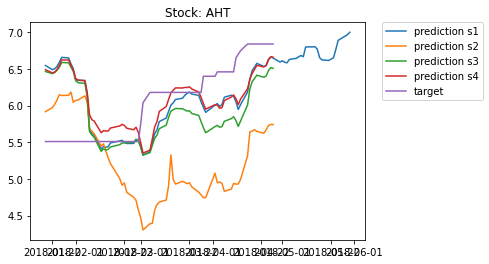

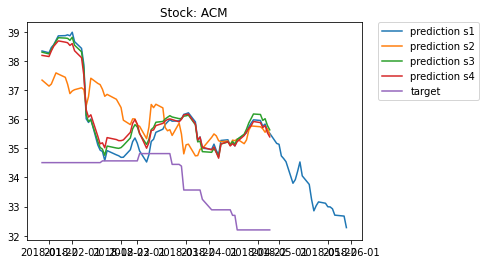

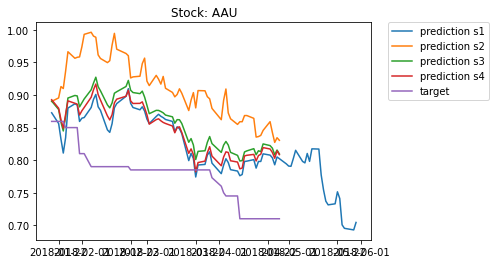

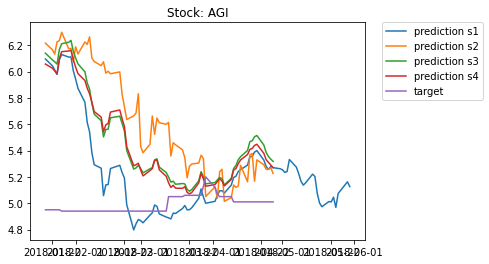

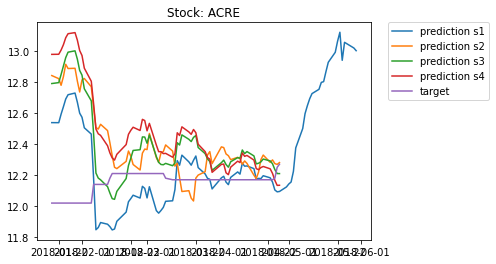

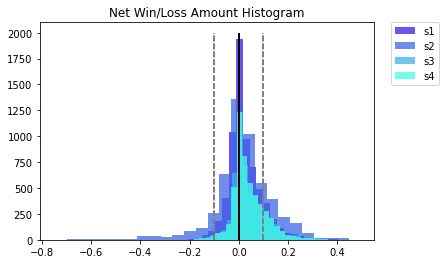

In [4]:
stocks = np.random.choice(df['symbol'].unique(), 5)
models = np.sort(df['model_id'].unique())
for s in stocks:
    temp = df[df['symbol']==s]
    for m in models:
        x = temp[temp['model_id']==m]
        plt.title(f'Stock: {s}')
        plt.plot(x['market_datetime'], x['prediction'], label=f'prediction {m}')
    plt.plot(x['market_datetime'], x['target'], label='target')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

color_offset = 0.1
for m in models:
    temp = df[df['model_id']==m]
    plt.title(f'Net Win/Loss Amount Histogram')
    plt.hist(temp['error'], bins=25, ls='dashed', lw=2, fc=(.25, color_offset, .9, .75), label=m)
    plt.vlines(-.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.vlines(0, ymin=0, ymax=2000, color='black')
    plt.vlines(.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    color_offset += .3
plt.show()

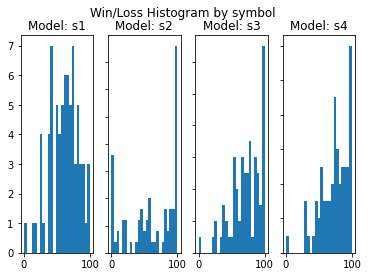

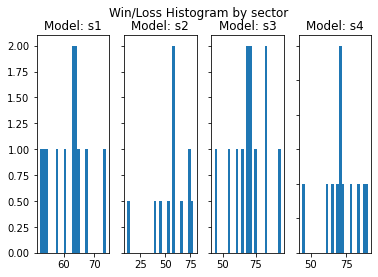

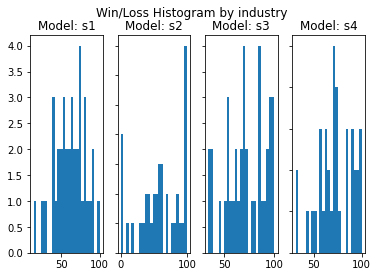

In [5]:
def groupby_plot(
    group
):
    query = f'''
        select
            model_id
          , {group}
          , 100 * sum(n_loss) / count(*) as loss_rate
        from dbt.evaluation
        group by 1,2
        '''
    df = utils.query_db(query=query)
    df.head(10)

    models = np.sort(df['model_id'].unique())
    n = len(models)

    fig, axs = plt.subplots(1, n)
    fig.suptitle(f'Win/Loss Histogram by {group}')
    for m in range(0, n):
        model = models[m]
        axs[m].set_title(f'Model: {model}')
        axs[m].hist(df.loc[df['model_id']==model, 'loss_rate'], bins=25)

    for ax in axs.flat:
        ax.label_outer()

    plt.show()

groupby_plot('symbol')
groupby_plot('sector')
groupby_plot('industry')

In [6]:
query = '''
    with
    s as (
    select distinct
        market_datetime::date
      , open / lag(open) over (order by market_datetime) as sp_open
    from yahoo.sp_index
    )
    select
        e.model_id
      , e.market_datetime
      , s.sp_open 
      , 100 * sum(e.n_loss) / count(*) as loss_rate
      , max(e.abs_error) as largest_daily_abs_error
      , avg(e.abs_error) as avg_abs_error
    from dbt.evaluation as e
    left join s
      on e.market_datetime = s.market_datetime
    group by 1,2,3
    order by 1,2,3
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,sp_open,loss_rate,largest_daily_abs_error,avg_abs_error
0,s1,2018-01-19,1.000071,83,0.310287,0.078540
1,s1,2018-01-22,1.002341,83,0.317880,0.077721
2,s1,2018-01-23,1.009216,82,0.314587,0.079955
3,s1,2018-01-24,1.003658,86,0.303680,0.081782
4,s1,2018-01-25,1.000288,87,0.312772,0.084658
5,s1,2018-01-26,1.000436,89,0.322721,0.087179
6,s1,2018-01-29,1.006936,91,0.310898,0.084128
7,s1,2018-01-30,0.987971,97,0.312917,0.085003
8,s1,2018-01-31,0.999883,93,0.315762,0.081255
9,s1,2018-02-01,0.994365,92,0.236839,0.079394


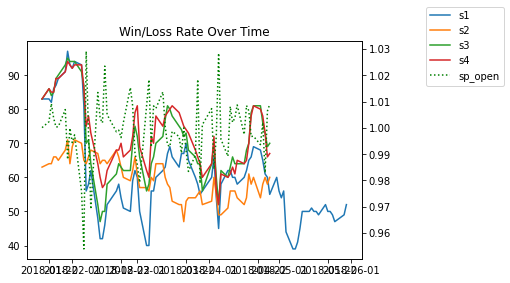

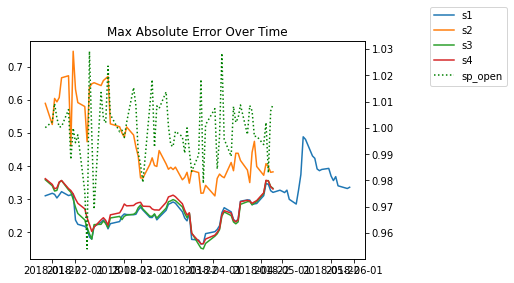

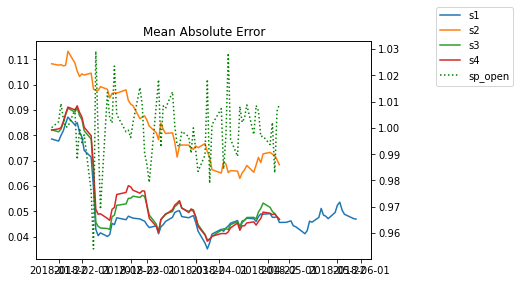

In [7]:
def multiplot(
    title,
    column,
):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    models = np.sort(df['model_id'].unique())
    for m in models:
        x = df[df['model_id']==m]
        plt.title(title)
        ax1.plot(x['market_datetime'], x[column], label=m)
    ax2.plot(x['market_datetime'], x['sp_open'], label='sp_open', color='g', linestyle=':')
    fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

multiplot(
    title = 'Win/Loss Rate Over Time',
    column = 'loss_rate',
)  

multiplot(
    title='Max Absolute Error Over Time',
    column='largest_daily_abs_error',
)

multiplot(
    title='Mean Absolute Error',
    column='avg_abs_error',
)